In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm.auto import tqdm
from torch.optim import Adam
from google.colab import drive
from torchsummary import summary
from matplotlib import pyplot as plt
from torchvision.datasets import Cityscapes
from torch.utils.data import Dataset, DataLoader
from typing import Any, Callable, Dict, List, Optional, Union, Tuple


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = Cityscapes('drive/MyDrive/ml_projects/Semantic-segmentation/data/', split='train', mode='fine',
                      target_type='semantic')

In [4]:
dataset[0][0].size

(2048, 1024)

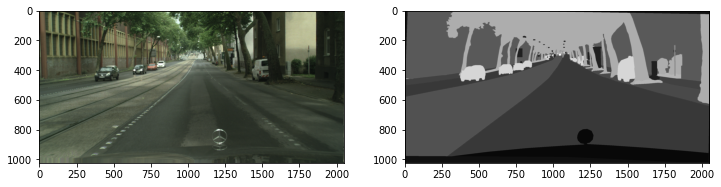

In [5]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

# Utility functions

label 
https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

function : https://github.com/meetps/pytorch-semseg/tree/master/ptsemseg

https://stackoverflow.com/a/64242989

In [6]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [7]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [8]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [9]:
def decode_segmap(temp):
    #convert gray scale to color
#     temp=temp.numpy()
    if not isinstance(temp, np.ndarray):
        temp=temp.numpy
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [10]:
img, msk = dataset[0]
msk = encode_segmap(np.array(msk))
msk

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

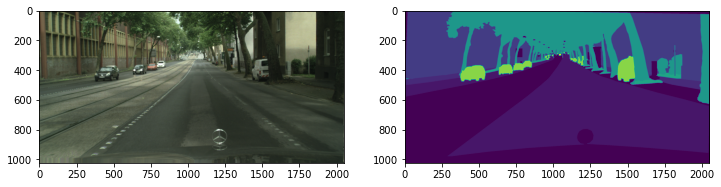

In [11]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(img)
ax[1].imshow(msk)

In [12]:
msk.shape

(1024, 2048)

In [13]:
msk = decode_segmap(msk)
msk

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [14]:
msk.shape

(1024, 2048, 3)

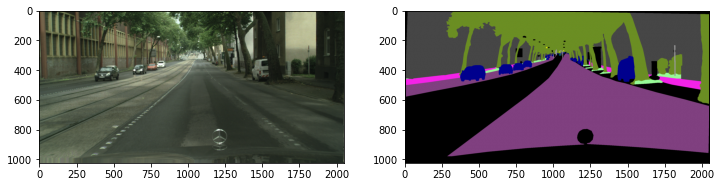

In [15]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(img)
ax[1].imshow(msk)

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(192, 384),
    ToTensorV2(),
]
)

In [17]:
class CityDataset(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']

# Model

In [18]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),   # out_c = n_filters
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=False),
            
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=False)
        )

        # self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):

        # p = self.pool(x)    #if want pooling, else p=x
        return self.double_conv(inputs)

In [19]:


class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            conv_block(in_c, out_c)       ######################
        )

    def forward(self, inputs):
        return self.maxpool_conv(inputs)




In [20]:

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=1)
        self.conv = conv_block(out_c+out_c, out_c)
        

    def forward(self, inputs, skip):
        x = self.up(inputs)
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = F.pad(x, (diffY//2, diffY-diffY//2, diffX//2, diffX-diffX//2))
        x = torch.cat([skip, x], axis=1)
        x = self.conv(x)

        return x


In [21]:

class outConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=1)

    def forward(self, inputs):
        return self.conv(inputs)


In [22]:

class build_unet(nn.Module):
    def __init__(self, in_c=3, batch_size=4, n_classes=20):    # shortened to 20 classes from 30
        super().__init__()
        self.in_c = in_c
        self.batch_size = batch_size
        self.n_classes = n_classes

        #Encoder
        self.b = conv_block(in_c, 64)
        self.e1 = encoder_block(64, 128)
        self.e2 = encoder_block(128, 256)
        self.e3 = encoder_block(256, 512)

        #Bottleneck
        self.e4 = encoder_block(512, 1024)

        #Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        #Classifier
        self.outputs = outConv(64, n_classes)  # 64, n_classes
        # self.rgbl = nn.Conv2d(30, 3, 3, padding=1)
        self.rel = nn.ReLU(inplace=False)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        #Encoder
        s1 = self.b(inputs)
        s2 = self.e1(s1)
        s3 = self.e2(s2)
        s4 = self.e3(s3)
        s5 = self.e4(s4)


        #Bottleneck
        # b = self.b(s4) to s5

        #Decoder
        d = self.d1(s5, s4)
        d = self.d2(d, s3)
        d = self.d3(d, s2)
        d = self.d4(d, s1)

        #Classifier

        # Change to output to have 3 channels to be compared to rgb mask, for that this layer needs to learn 30 values of r, g, b each
#         outputs = self.rgbl(out)
        # outputs = self.rel(out)     ReLu already to previous layer
        outputs = self.outputs(d)
        
#         outputs = self.softmax(outputs)
        
        # and finally here it comes, the argmax layer
        # outputs = torch.argmax(outputs, dim = 1)

        return outputs


Training Measures

#    Define metrics

In [ ]:
# from ignite.engine import Engine
# from ignite.metrics import ConfusionMatrix, IoU, Recall

# def eval_step(engine, batch):
#     return batch

# default_evaluator = Engine(eval_step)
# cm = ConfusionMatrix(num_classes=20)
# metric = IoU(cm)
# metrica = Recall()
# macro_metric = Recall(average=True)

# metric.attach(default_evaluator, 'iou')
# metrica.attach(default_evaluator, "recall")
# macro_metric.attach(default_evaluator, "macro recall")

# state = default_evaluator.run([[y_pred, y_true]])
# iou = state.metrics['iou']
# recall = state.metrics['recall']
# macro_recall = state.metrics['macro recall']

apply argmax to the output and then compare with the label as i(0,19) corresponds to respective rgb values. For both iou and accuracy (recall).
e.g. like where intersection = cl10(inpred)==cl10(inlbl), union = cl10(pred)+cl10(inlbl)-intersection

In [23]:
def IoUacc(pred, mask, n_classes=20):

  preds = torch.argmax(pred, dim=1)
  ious = []
  accs = []
  # pred = pred.view(-1)
  # target = target.view(-1)
  # Ignore IoU for background class ("0")

  for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
    pred_inds = preds == cls
    target_inds = mask == cls
    intersection = torch.sum(pred_inds*target_inds).item()

    # intersection = (pred_inds[target_inds]).long().sum().data.cpu()[0]  # Cast to long to prevent overflows
    union = (torch.sum(pred_inds) + torch.sum(target_inds) - intersection).item()
    
    if union == 0:
      ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / float(max(union, 1)))
    accs.append(float(intersection))
    
  acc = sum(accs)
  iou = sum(ious)/len(ious)
  return iou, acc
  # return np.array(ious)


In [24]:
train_data = CityDataset('drive/MyDrive/ml_projects/Semantic-segmentation/data/', split='train', mode='fine', target_type='semantic', transforms=transform)
val_data = CityDataset('drive/MyDrive/ml_projects/Semantic-segmentation/data/', split='val', mode='fine', target_type='semantic', transforms=transform)

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [25]:
# import segmentation_models_pytorch as smp
# import torchmetrics

segModel = build_unet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
segModel.to(device)

torch.cuda.empty_cache()
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:256.0'

loss_fn = torch.nn.CrossEntropyLoss()   # smp.losses.DiceLoss(mode='multiclass')     # BCEWithLogitsLoss() for binary classification
# metrics = torchmetrics.IoU(20)      # n_classes=20  iou ~ jaccard index

# changing lr 
optimizer = Adam(segModel.parameters(), lr=0.00099, weight_decay=0.003)

summary(segModel, (3, 192, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 384]           1,792
       BatchNorm2d-2         [-1, 64, 192, 384]             128
              ReLU-3         [-1, 64, 192, 384]               0
            Conv2d-4         [-1, 64, 192, 384]          36,928
       BatchNorm2d-5         [-1, 64, 192, 384]             128
              ReLU-6         [-1, 64, 192, 384]               0
        conv_block-7         [-1, 64, 192, 384]               0
         MaxPool2d-8          [-1, 64, 96, 192]               0
            Conv2d-9         [-1, 128, 96, 192]          73,856
      BatchNorm2d-10         [-1, 128, 96, 192]             256
             ReLU-11         [-1, 128, 96, 192]               0
           Conv2d-12         [-1, 128, 96, 192]         147,584
      BatchNorm2d-13         [-1, 128, 96, 192]             256
             ReLU-14         [-1, 128, 

In [35]:

def testAccuracy():
    segModel.eval()
#     accuracy=0
#     total=0

    avg_iou = 0
    avg_macro_recall = 0
    avg_loss = 0
    with torch.no_grad():
        for (x, y) in val_dataloader:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            # device = torch.device('cpu')
            typ = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
            y = encode_segmap(y)
            x, y = (x.to(device)).type(typ), (y.to(device)).type(typ)
            y = y.long()
            outputs = segModel(x)
            
#             y = y.type(torch.LongTensor)
#             predicted = torch.argmax(outputs)
#             total+=y.size(0)
#             corr = (outputs==y).sum().item()
#             accuracy = accuracy + corr

            # state = default_evaluator.run([[outputs, y]])
            # iou = state.metrics['iou']

            iou, acc = IoUacc(outputs, y, 20)
            avg_iou += (iou)/20        #.sum().item() len(iou) = 20 (n_classes)
            # macro_recall = state.metrics['macro recall']

            
            avg_macro_recall += acc
            loss = loss_fn(outputs, y)
            avg_loss += loss.item()
    segModel.train()
    
#     accuracy = (100.*accuracy/500)/256/256/3    # compute accuracy over all test images 500~len(testset)
    avg_iou = (avg_iou/len(val_dataloader))
    avg_macro_recall = (avg_macro_recall/len(val_dataloader))*100
    avg_loss = (avg_loss/len(val_dataloader))
    
    return avg_iou, avg_macro_recall, avg_loss


In [27]:

def savemodel(bst):
    if bst == 'acc':
        path = 'drive/MyDrive/ml_projects/Semantic-segmentation/Models/segModelacc.pth'
    elif bst == 'iou':
        path = 'drive/MyDrive/ml_projects/Semantic-segmentation/Models/segModeliou.pth'
    elif bst == 'tloss':
        path = 'drive/MyDrive/ml_projects/Semantic-segmentation/Models/segModeltloss.pth'
    torch.save(segModel.state_dict(), path)
    # torch.save(model, PATH)


Load saved model

In [28]:
# segModel = build_unet()     # if not already defined
path = 'drive/MyDrive/ml_projects/Semantic-segmentation/Models/segModeltloss.pth'
segModel.load_state_dict(torch.load(path))

<All keys matched successfully>

# Training

In [30]:

def trainseg(num_epochs, rl, vl, vi, va):
    
    best_accuracy = 0.0
    best_iou = 0.0
    least_loss = 1e6
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    typ = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    # device = torch.device('cpu')

    segModel.to(device)
    segModel.train()

    for epoch in tqdm(range(num_epochs), position=0, desc='epochs', leave=True):  # , ncols-70
        running_loss = 0.0
#         avg_iou = 0
#         running_acc = 0.0
        torch.cuda.empty_cache()
        segModel.train()

        for (img, mask) in tqdm(train_dataloader, position=1, desc='batches', leave=False): # , ncols=70
            mask = encode_segmap(mask)
            img, mask = (img.to(device)).type(typ), (mask.to(device)).type(typ)
            mask = mask.long()
            optimizer.zero_grad()
            outputs = segModel(img)
            loss = loss_fn(outputs, mask)
#             iou = metrics(outputs, mask)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
#             avg_iou += iou.item()
#             running_acc += (outputs==mask).sum().item()
        training_loss = running_loss/2975
        # val_iou, val_macro_recall, val_loss = testAccuracy()
        
        rl.append(training_loss)
        np.save('drive/MyDrive/ml_projects/Semantic-segmentation/Models/tlosses', rl)
        # vl.append(val_loss)
        # vi.append(val_iou)
        # va.append(val_macro_recall)
        
        print(f'epoch {epoch+1} -> training_loss: {training_loss}')   # \t val_loss: {val_loss} \t val_iou: {val_iou} \t val_macro_recall(val_accuracy): {val_macro_recall}')    # \t avg_train_iou: {avg_iou/2975} \t  '\t', f'trainAccuracy: {100.*running_acc/2975/256/256/3}','\t', 'valAccuracy:', testAccuracy()
#         print()
        
        if training_loss<least_loss:
            savemodel('tloss')
            least_loss=training_loss
            
        # if val_macro_recall>best_accuracy:
        #     savemodel('acc')
        #     best_accuracy=val_macro_recall
            
        # if val_iou>best_iou:
        #     savemodel('iou')
        #     best_iou=val_iou


In [31]:
training_losses = [0.07093624439560064,
                   0.05286190724172512,
                   0.0512383160070211,
                   0.046120756874565315,
                   0.04384280395107109,
                   0.04223280530015962,
                   0.04105607881265528,
                   0.03944476967098332,
                   0.038718825628777515,
                   0.03672157164381332,
                   0.03586735024171717,
                   0.03522335246831429,
                   0.0338291581538545,
                   0.03336764333628807,
                   0.032619405704386095,
                   0.0324266340452082,
                   0.03265314043069086,
                   0.0314816084128468,
                   0.03123241492680141,
                   0.03104568957280712,
                   0.030503309634553284,
                   0.030117270265306747,
                   0.03004514417728456,
                   0.029451256098867465,
                   0.029899179124030745,
                   0.029635903975542853,
                   0.029293320289179057,
                   0.029477065160494892,
                   0.029478303214081195,
                   0.029246616293402278,
                   0.028811459100546957,
                   0.028809801199856926,
                   0.028666250395173787,
                   0.02867499411606989,
                   0.028670881746195944,
                   0.02849207878112793]    # running loss
# load this np array for updated values
val_losses = []
val_ious = []
val_accuracys = []

num_epochs = 1

trainseg(num_epochs, training_losses, val_losses, val_ious, val_accuracys)

epochs:   0%|          | 0/1 [00:00<?, ?it/s]

batches:   0%|          | 0/186 [00:00<?, ?it/s]

epoch 1 -> training_loss: 0.028064602052464204


In [32]:
training_losses

[0.07093624439560064,
 0.05286190724172512,
 0.0512383160070211,
 0.046120756874565315,
 0.04384280395107109,
 0.04223280530015962,
 0.04105607881265528,
 0.03944476967098332,
 0.038718825628777515,
 0.03672157164381332,
 0.03586735024171717,
 0.03522335246831429,
 0.0338291581538545,
 0.03336764333628807,
 0.032619405704386095,
 0.0324266340452082,
 0.03265314043069086,
 0.0314816084128468,
 0.03123241492680141,
 0.03104568957280712,
 0.030503309634553284,
 0.030117270265306747,
 0.03004514417728456,
 0.029451256098867465,
 0.029899179124030745,
 0.029635903975542853,
 0.029293320289179057,
 0.029477065160494892,
 0.029478303214081195,
 0.029246616293402278,
 0.028811459100546957,
 0.028809801199856926,
 0.028666250395173787,
 0.02867499411606989,
 0.028670881746195944,
 0.02849207878112793,
 0.028064602052464204]

In [36]:
print(testAccuracy())   # val_iou, val_macro_recall/accuracy, val_loss

(nan, 87904168.75, 0.5192326791584492)


In [ ]:
# trainseg(20, training_losses, val_losses, val_ious, val_accuracys)

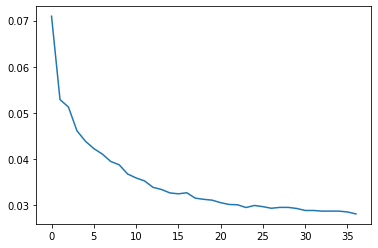

In [33]:

plt.plot(training_losses)

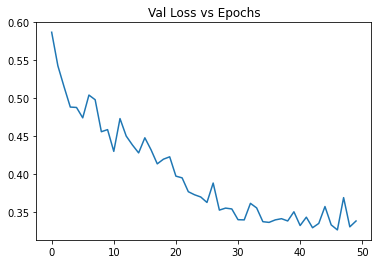

In [ ]:
# fig,ax=plt.subplots(ncols=3)     # ,figsize=(12,8)
plt.title('Val Loss vs Epochs')
plt.plot(val_losses)

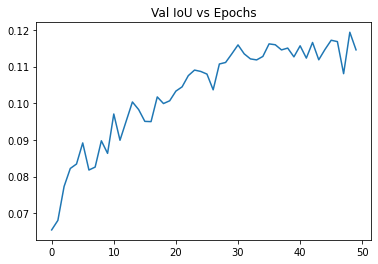

In [ ]:

plt.title('Val IoU vs Epochs')
plt.plot(val_ious)

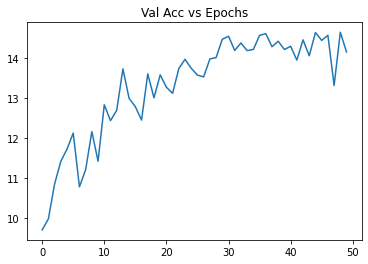

In [ ]:

plt.title('Val Acc vs Epochs')
plt.plot(val_accuracys)

In [ ]:
img_path = ('drive/MyDrive/ml_projects/Semantic-segmentation/data/leftImg8bit/test/munich/munich_000001_000019_leftImg8bit.png')
image = Image.open(img_path).convert('RGB')
transformed=transform(image=np.array(image))            
img = transformed['image']
img.shape

torch.Size([3, 192, 384])

#Predicting

In [ ]:
def cheqModel(img_path):
    image = Image.open(img_path).convert('RGB')
    transformed=transform(image=np.array(image))            
    img = transformed['image']
    imag = img[None, :]
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    typ = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    segModel.to(device)
    out = segModel(imag.to(device).type(typ))
    
    p = torch.argmax(out, axis=1)
    plt.imshow(np.array(p.cpu().squeeze()))
    return

In [ ]:
imag = img[None, :]
imag.shape

torch.Size([1, 3, 192, 384])

In [ ]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
typ = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

out = segModel(imag.to(device).type(typ))

In [ ]:
out.shape

torch.Size([1, 20, 192, 384])

In [ ]:
p = torch.argmax(out, axis=1)
p.shape

torch.Size([1, 192, 384])

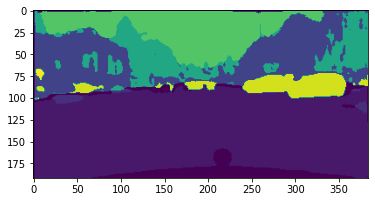

In [ ]:
plt.imshow(np.array(p.cpu().squeeze()))

In [ ]:
torch.unique(p)

tensor([ 0,  1,  2,  3,  4,  5,  9, 10, 11, 14, 15], device='cuda:0')

In [ ]:
torch.max(out)

tensor(26214.8301, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
testAccuracy()

(0.11722510150088084, 14.56101759628005, 0.3462142681479454)